In [1]:
from timm import create_model

In [2]:
from fastai.vision.all import *

In [3]:
set_seed(2999, reproducible=True)
BATCH_SIZE = 8

In [4]:
dataset_path = Path('../datasets/kaggle/petfinder/')
dataset_path.ls()

(#10) [Path('../datasets/kaggle/petfinder/train_5folds.csv'),Path('../datasets/kaggle/petfinder/train_10folds.csv'),Path('../datasets/kaggle/petfinder/test.csv'),Path('../datasets/kaggle/petfinder/train.csv'),Path('../datasets/kaggle/petfinder/test'),Path('../datasets/kaggle/petfinder/sample_submission.csv'),Path('../datasets/kaggle/petfinder/archive.zip'),Path('../datasets/kaggle/petfinder/train'),Path('../datasets/kaggle/petfinder/crop'),Path('../datasets/kaggle/petfinder/petfinder-pawpularity-score.zip')]

In [5]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,1,1,1,0,1,0,0,0,0,0,0,27,../datasets/kaggle/petfinder/train/fa123435b35cf07a6c53f8d5a5c36f6c.jpg
1,0,1,1,1,0,0,0,0,0,0,0,0,30,../datasets/kaggle/petfinder/train/d7d222be164177b8a1033fb51a5d762f.jpg
2,0,1,1,1,0,0,1,0,0,0,0,0,26,../datasets/kaggle/petfinder/train/62caf65e5c6ae1d881d1bb986b609011.jpg
3,0,1,1,1,0,0,0,0,0,0,0,0,24,../datasets/kaggle/petfinder/train/c2243c99e0a96d5e0dfbb9b00e922bed.jpg
4,0,1,1,1,0,0,0,0,0,0,0,0,75,../datasets/kaggle/petfinder/train/ddcffbbc1a816adbbe38339f19c6b5f9.jpg


In [7]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774435


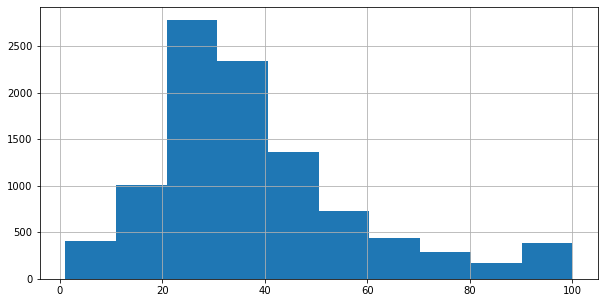

In [8]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [9]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.27
1       0.30
2       0.26
3       0.24
4       0.75
        ... 
9907    0.97
9908    0.24
9909    0.34
9910    0.56
9911    0.49
Name: norm_score, Length: 9912, dtype: float64

In [10]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [11]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins

<AxesSubplot:>

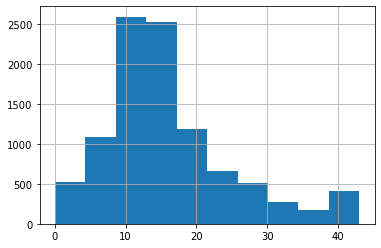

In [12]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

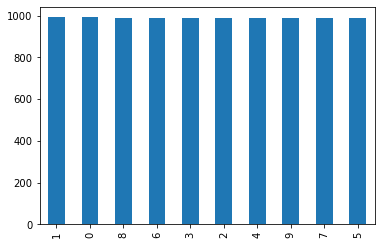

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [14]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [15]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

In [16]:
#Valid Kfolder size
the_data = get_data(0)
# assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [17]:
import torch
import torch.nn as nn


class PetModel(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        return pred

class PetModelForCB(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        out = torch.cat([pred, features], dim=1)
        return out


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('res2next50', num_classes=num_classes, pretrained=True)

#     def forward(self, x):
#         x = self.model.forward_features(x)
#         x = self.model.global_pool(x)
#         if self.model.drop_rate > 0.:
#             x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
#         return self.model.fc(x)

# class PetModelForCB(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('res2next50', num_classes=num_classes, pretrained=True)

#     def forward(self, x):
#         self.eval()
#         features = self.model.forward_features(x)
#         x = self.model.global_pool(features)
#         if self.model.drop_rate > 0.:
#             x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
#         pred = self.model.fc(x)
#         out = torch.cat([pred, features], dim=1)
#         return out

# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('efficientnet_b0', num_classes=num_classes, pretrained=True)

#     def forward(self, x):
#         x = self.model.forward_features(x)
#         x = self.model.global_pool(x)
#         if self.model.drop_rate > 0.:
#             x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
#         return self.model.classifier(x)

# class PetModelForCB(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('efficientnet_b0', num_classes=num_classes, pretrained=True)

#     def forward(self, x):
#         self.eval()
#         features = self.model.forward_features(x)
#         x = self.model.global_pool(features)
#         if self.model.drop_rate > 0.:
#             x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
#         pred = self.model.classifier(x)
#         out = torch.cat([pred, features], dim=1)
#         return out



In [18]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = PetModel(num_classes=data.c)

    learn = Learner(
        data, 
        model, 
        loss_func=BCEWithLogitsLossFlat(), 
        metrics=AccumMetric(func = petfinder_rmse),
        model_dir = "vit_large_patch16_224_bs8_10fold_10epoch_seed2999"
    ).to_fp16()
    
    return learn

In [19]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [20]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

SuggestedLRs(valley=4.256162355886772e-05)

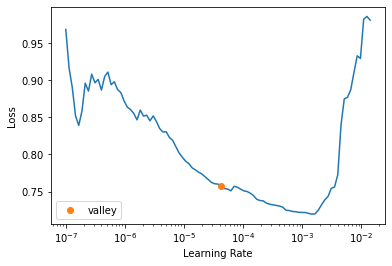

In [21]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658679,0.657770,19.774406,03:10
1,0.647944,0.646776,18.474140,03:10
2,0.642500,0.647873,18.588043,03:10
3,0.642892,0.644242,18.140753,03:10
4,0.633229,0.644275,18.086685,03:10
5,0.618463,0.649875,18.709679,03:10
6,0.627385,0.648856,18.557734,03:10


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.77440643310547.
Better model found at epoch 1 with petfinder_rmse value: 18.474140167236328.
Better model found at epoch 3 with petfinder_rmse value: 18.1407527923584.
Better model found at epoch 4 with petfinder_rmse value: 18.086685180664062.
No improvement since epoch 4: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.652082,0.656771,19.607916,03:10
1,0.646667,0.652718,19.069948,03:10
2,0.650493,0.642971,17.863911,03:10
3,0.640262,0.643458,17.898073,03:10
4,0.639592,0.644751,18.072651,03:10


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.6079158782959.
Better model found at epoch 1 with petfinder_rmse value: 19.069948196411133.
Better model found at epoch 2 with petfinder_rmse value: 17.863910675048828.
No improvement since epoch 2: early stopping


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658480,0.649731,18.765867,03:10
1,0.647509,0.642278,17.805109,03:10
2,0.648428,0.639519,17.452728,03:10
3,0.643487,0.639850,17.465723,03:11
4,0.642097,0.637305,17.127415,03:10
5,0.632553,0.645247,18.044817,03:10
6,0.622359,0.644922,17.943373,03:10


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.765867233276367.
Better model found at epoch 1 with petfinder_rmse value: 17.80510902404785.
Better model found at epoch 2 with petfinder_rmse value: 17.452728271484375.
Better model found at epoch 4 with petfinder_rmse value: 17.12741470336914.
No improvement since epoch 4: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653612,0.652322,19.177811,03:10
1,0.651117,0.642833,17.966095,03:10
2,0.645857,0.643284,18.026182,03:10
3,0.642310,0.641383,17.780350,03:10
4,0.645421,0.646356,18.374069,03:11
5,0.626029,0.645457,18.193663,03:11


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.177810668945312.
Better model found at epoch 1 with petfinder_rmse value: 17.966094970703125.
Better model found at epoch 3 with petfinder_rmse value: 17.780349731445312.
No improvement since epoch 3: early stopping


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.660984,0.651583,18.987093,03:10
1,0.652719,0.643623,17.976229,03:10
2,0.644819,0.638099,17.232765,03:10
3,0.645015,0.640320,17.515928,03:10
4,0.641814,0.641475,17.657331,03:10


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.987092971801758.
Better model found at epoch 1 with petfinder_rmse value: 17.976228713989258.
Better model found at epoch 2 with petfinder_rmse value: 17.232765197753906.
No improvement since epoch 2: early stopping


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650525,0.657947,19.738897,03:10
1,0.646646,0.650322,18.841816,03:10
2,0.644514,0.645376,18.189171,03:10
3,0.632043,0.650356,18.713282,03:11
4,0.629652,0.646057,18.206532,03:11


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.7388973236084.
Better model found at epoch 1 with petfinder_rmse value: 18.841815948486328.
Better model found at epoch 2 with petfinder_rmse value: 18.189170837402344.
No improvement since epoch 2: early stopping


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.660554,0.649251,18.792646,03:10
1,0.651422,0.644569,18.172092,03:10
2,0.646408,0.641320,17.774277,03:10
3,0.644213,0.640179,17.640526,03:10
4,0.631928,0.643876,18.067282,03:11
5,0.625154,0.642481,17.874107,03:11


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.792646408081055.
Better model found at epoch 1 with petfinder_rmse value: 18.17209243774414.
Better model found at epoch 2 with petfinder_rmse value: 17.774276733398438.
Better model found at epoch 3 with petfinder_rmse value: 17.640525817871094.
No improvement since epoch 3: early stopping


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.659049,0.651195,19.093885,03:10
1,0.653727,0.641802,17.874905,03:11
2,0.653227,0.640196,17.662012,03:11
3,0.642378,0.641790,17.851065,03:10
4,0.638632,0.642237,17.915096,03:11


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.09388542175293.
Better model found at epoch 1 with petfinder_rmse value: 17.87490463256836.
Better model found at epoch 2 with petfinder_rmse value: 17.662012100219727.
No improvement since epoch 2: early stopping


Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647883,0.653045,19.302917,03:10
1,0.653115,0.640852,17.807131,03:10
2,0.641792,0.644298,18.287022,03:11
3,0.647887,0.640303,17.717173,03:11
4,0.631441,0.642413,17.930048,03:11
5,0.631162,0.639772,17.666468,03:10
6,0.612213,0.643708,18.122282,03:10
7,0.619167,0.644650,18.272776,03:10


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.30291748046875.
Better model found at epoch 1 with petfinder_rmse value: 17.807130813598633.
Better model found at epoch 3 with petfinder_rmse value: 17.717172622680664.
Better model found at epoch 5 with petfinder_rmse value: 17.666467666625977.
No improvement since epoch 5: early stopping


Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651804,0.650818,18.953697,03:10
1,0.647154,0.647120,18.483459,03:11
2,0.646283,0.645079,18.228724,03:10
3,0.638677,0.641845,17.799994,03:11
4,0.637421,0.643493,17.972126,03:11
5,0.634687,0.644361,18.086006,03:11


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.953697204589844.
Better model found at epoch 1 with petfinder_rmse value: 18.48345947265625.
Better model found at epoch 2 with petfinder_rmse value: 18.228723526000977.
Better model found at epoch 3 with petfinder_rmse value: 17.79999351501465.
No improvement since epoch 3: early stopping


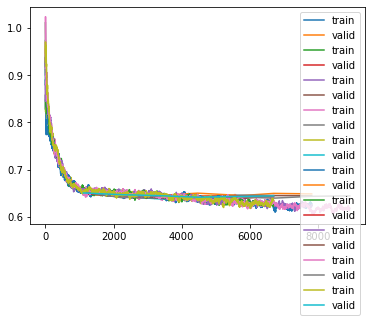

In [22]:
import gc
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)
    mixup = MixUp(0.4)
    learn.fit_one_cycle(
        10, 
        4e-6, 
        cbs=[
            SaveModelCallback(
                monitor='petfinder_rmse', 
                comp=np.less, 
                fname=f'vit_large_patch16_224_fold{i}',
                # at_end = True
            ), 
            EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2), 
            mixup
        ]
    ) 
    
    learn.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [23]:
print("end")

end
